In [2]:
!kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51           8817        285  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           7189        170  1.0              
amaanansari09/top-100-songs                                Top 100 songs                                 6KB  2023-02-16 18:55:35           2157         72  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:2

In [3]:
!kaggle datasets list -s flowers

ref                                     title                                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------  -----------------------------------  ------  -------------------  -------------  ---------  ---------------  
alxmamaev/flowers-recognition           Flowers Recognition                   225MB  2021-07-16 16:00:32          81805       1721  0.625            
l3llff/flowers                          🌸 | Flowers                           228MB  2022-04-29 20:37:05           2627         58  0.875            
imsparsh/flowers-dataset                Flowers Dataset                       205MB  2021-02-19 21:41:06           1876         28  0.9411765        
cdeotte/oxford-flowers-tfrecords        Oxford Flowers TFRecords                6GB  2020-03-12 16:20:14            163         45  0.625            
muhammedtausif/rose-flowers             Rose Flowers                          191MB  2022-04-03 17:3

In [4]:
!kaggle datasets download -d alxmamaev/flowers-recognition


  0%|          | 0.00/225M [00:00<?, ?B/s]
  0%|          | 1.00M/225M [00:00<03:33, 1.10MB/s]
  1%|          | 2.00M/225M [00:02<03:52, 1.00MB/s]
  1%|▏         | 3.00M/225M [00:03<03:59, 970kB/s] 
  2%|▏         | 4.00M/225M [00:04<03:55, 983kB/s]
  2%|▏         | 5.00M/225M [00:05<03:54, 981kB/s]
  3%|▎         | 6.00M/225M [00:06<03:54, 977kB/s]
  3%|▎         | 7.00M/225M [00:07<03:53, 977kB/s]
  4%|▎         | 8.00M/225M [00:08<03:54, 969kB/s]
  4%|▍         | 9.00M/225M [00:09<03:51, 978kB/s]
  4%|▍         | 10.0M/225M [00:10<03:50, 975kB/s]
  5%|▍         | 11.0M/225M [00:11<03:50, 973kB/s]
  5%|▌         | 12.0M/225M [00:12<03:49, 971kB/s]
  6%|▌         | 13.0M/225M [00:13<03:48, 972kB/s]
  6%|▌         | 14.0M/225M [00:15<03:46, 974kB/s]
  7%|▋         | 15.0M/225M [00:16<03:46, 972kB/s]
  7%|▋         | 16.0M/225M [00:17<03:45, 971kB/s]
  8%|▊         | 17.0M/225M [00:18<03:44, 972kB/s]
  8%|▊         | 18.0M/225M [00:19<03:42, 973kB/s]
  8%|▊         | 19.0M/225M [00:20<

In [5]:
# Unzip the dataset
!tar -xf flowers-recognition.zip

In [17]:
from PIL import Image
import torch
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor

def compute_gradients(function, inp, **kwargs):
    inp.requires_grad = True
    loss = function(inp, **kwargs)
    loss.backward()
    inp.requires_grad = False
    #print(inp.grad.data.shape)
    return inp.grad.data

def read_image(path):
    img = Image.open(path)
    transform = Compose([Resize(256), CenterCrop(224), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    tensor_ = transform(img)
    tensor_ = tensor_.unsqueeze(0)
    
    return tensor_

def to_array(tensor):
    tensor_ = tensor.squeeze(0)
    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]), Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])
    
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()
    
    return arr

def scale_grad(grad):
    grad_arr = torch.abs(grad).mean(dim=1).detach().permute(1,2,0)
    grad_arr = grad_arr / grad_arr.quantile(0.98)
    grad_arr = torch.clamp(grad_arr, 0, 1)
    #print(grad_arr.shape)
    return grad_arr.numpy()


    

In [18]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
from torchvision.models import resnet18, ResNet18_Weights

def func(input, net=None, target=None):
    out = net(input)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))
    
    print("Loss: ", loss.item())
    
    return loss

def attack(tensor, net, eps=1e-3, n_iter=50):
    
    new_tensor = tensor.clone()
    orig_prediction = net(tensor).argmax().item()
    
    print("Original prediction: ", orig_prediction)
    
    for i in range(n_iter):
        net.zero_grad()
        
        grad = compute_gradients(func, new_tensor, net=net, target=orig_prediction)
        
        new_tensor = torch.clamp(new_tensor + eps * torch.sign(grad),-2,2)
        
        new_prediction = net(new_tensor).argmax().item()
        
        if(new_prediction != orig_prediction):
            print("New prediction: ", new_prediction)
            break
        
    return new_tensor, new_prediction, orig_prediction

Original prediction:  207
Loss:  -13.085577011108398
Loss:  -11.786746978759766
Loss:  -10.576491355895996
Loss:  -9.489070892333984
Loss:  -8.488283157348633
Loss:  -7.541096210479736
Loss:  -6.668887615203857
New prediction:  266


Text(0.5, 1.0, 'Difference')

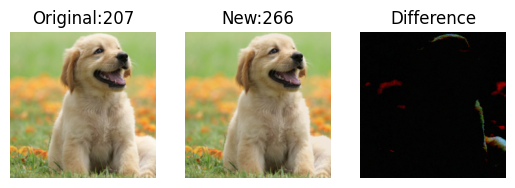

In [20]:
net = resnet18(weights = ResNet18_Weights.DEFAULT)
net.eval()

img = read_image("dog-puppy-on-garden-royalty-free-image-1586966191.jpg")

new_tensor, new_prediction, orig_prediction = attack(img, net, eps=1e-3, n_iter=100)

_, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3)
arr = to_array(img)
new_arr = to_array(new_tensor)
diff_arr = np.abs(arr - new_arr)
diff_arr = diff_arr / diff_arr.max()

ax_orig.imshow(arr)
ax_new.imshow(new_arr)
ax_diff.imshow(diff_arr)

ax_orig.axis("off")
ax_new.axis("off")
ax_diff.axis("off")

ax_orig.set_title(f"Original:{orig_prediction}")
ax_new.set_title(f"New:{new_prediction}")
ax_diff.set_title("Difference")